In [ ]:
pip install stable-baselines3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 31.2 MB/s eta 0:00:00


In [ ]:
pip install yfinance

In [ ]:
pip install tensorflow

[*********************100%***********************]  1 of 1 completed

Fetching data for BTC-USD...
Data fetched: 1826 rows.
Adding technical indicators...
Technical indicators added: 1627 rows remain.
Epoch 1/50


16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 106ms/step - loss: 8.3060 - mae: 0.7872 - mse: 0.9920 - val_loss: 6.9965 - val_mae: 0.2971 - val_mse: 0.1450
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 7.2187 - mae: 0.5805 - mse: 0.5351 - val_loss: 6.2509 - val_mae: 0.2115 - val_mse: 0.0847
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 6.3717 - mae: 0.4876 - mse: 0.3737 - val_loss: 5.5471 - val_mae: 0.1554 - val_mse: 0.0504
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 5.6280 - mae: 0.4265 - mse: 0.2878 - val_loss: 4.9546 - val_mae: 0.2080 - val_mse: 0.0770
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 4.9829 - mae: 0.3961 - mse: 0.2488 - val_loss: 4.3669 - val_mae: 0.1612 - val_mse: 0.0548
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 4.3860 - mae: 0.3529 - mse: 0.2033 - val_loss: 3.8451 - val_mae: 0.1520 - val_mse: 0.0405
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 3.8645 - mae: 0.3333 - mse: 0.1747 - val_loss: 3.4295 - v

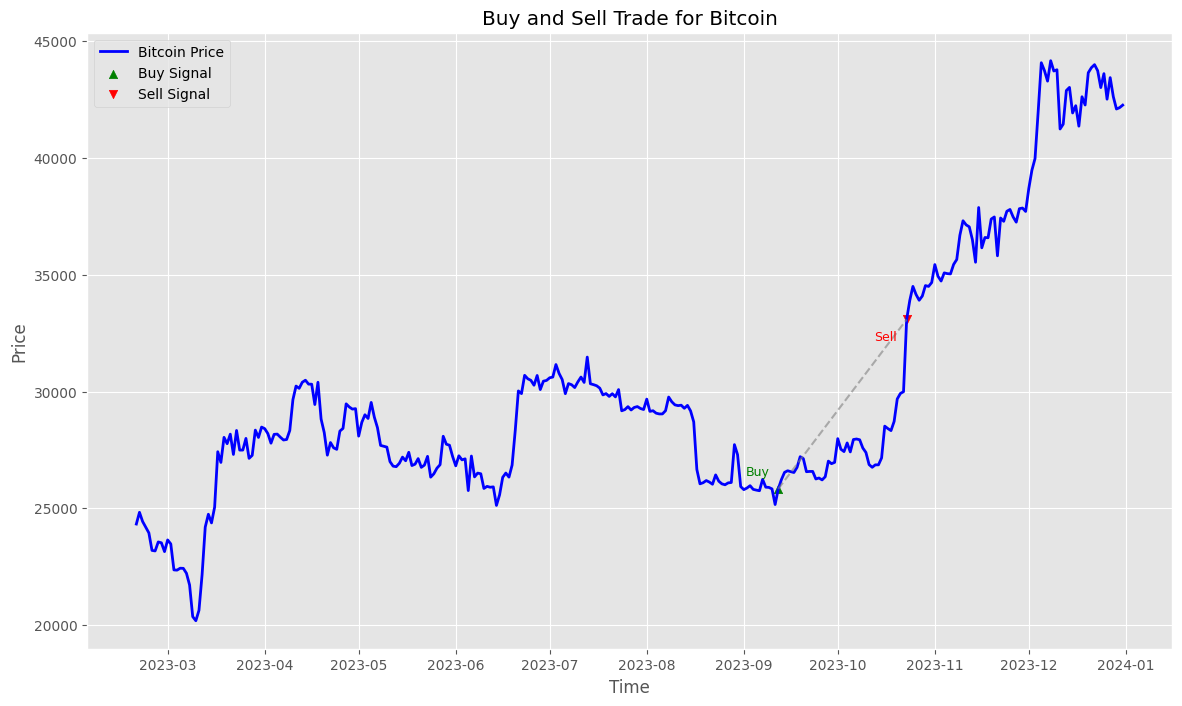

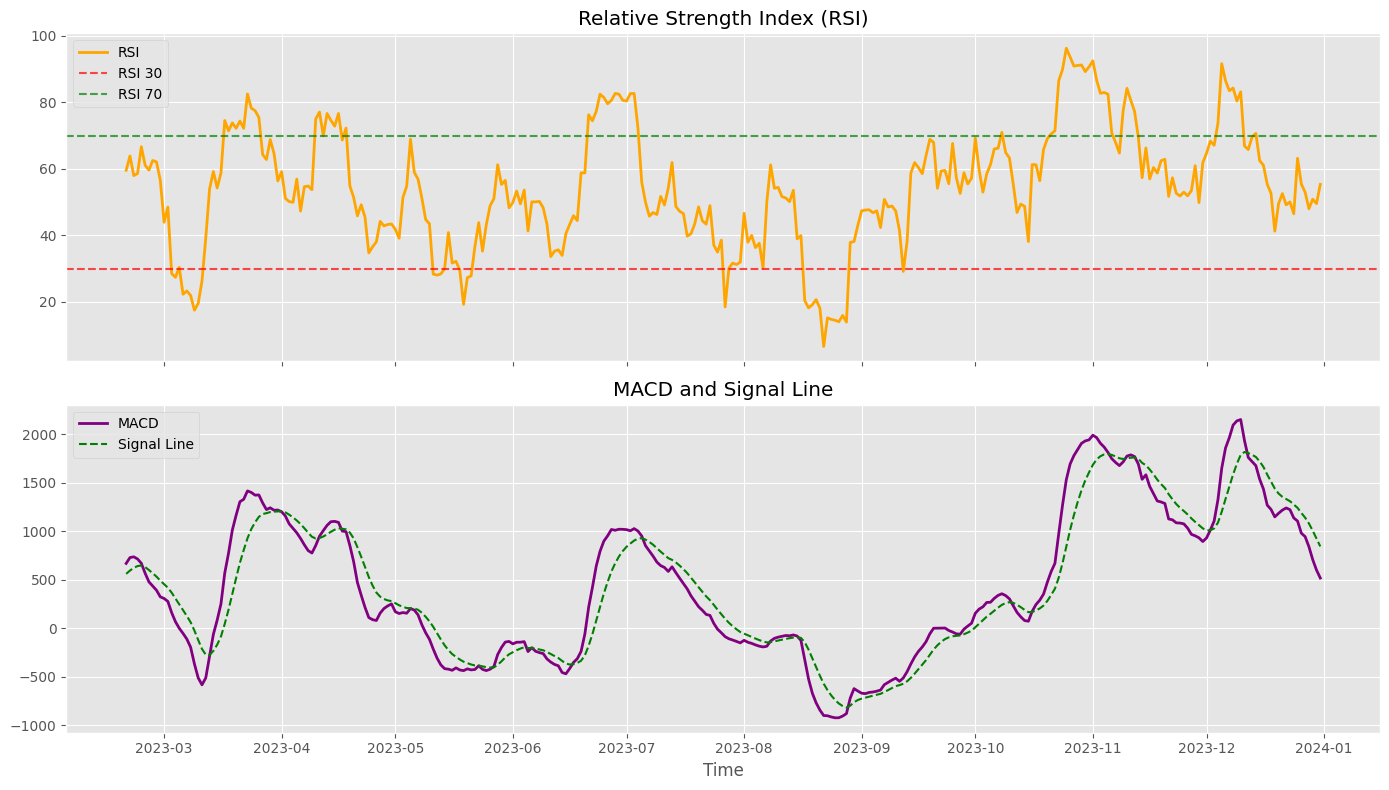

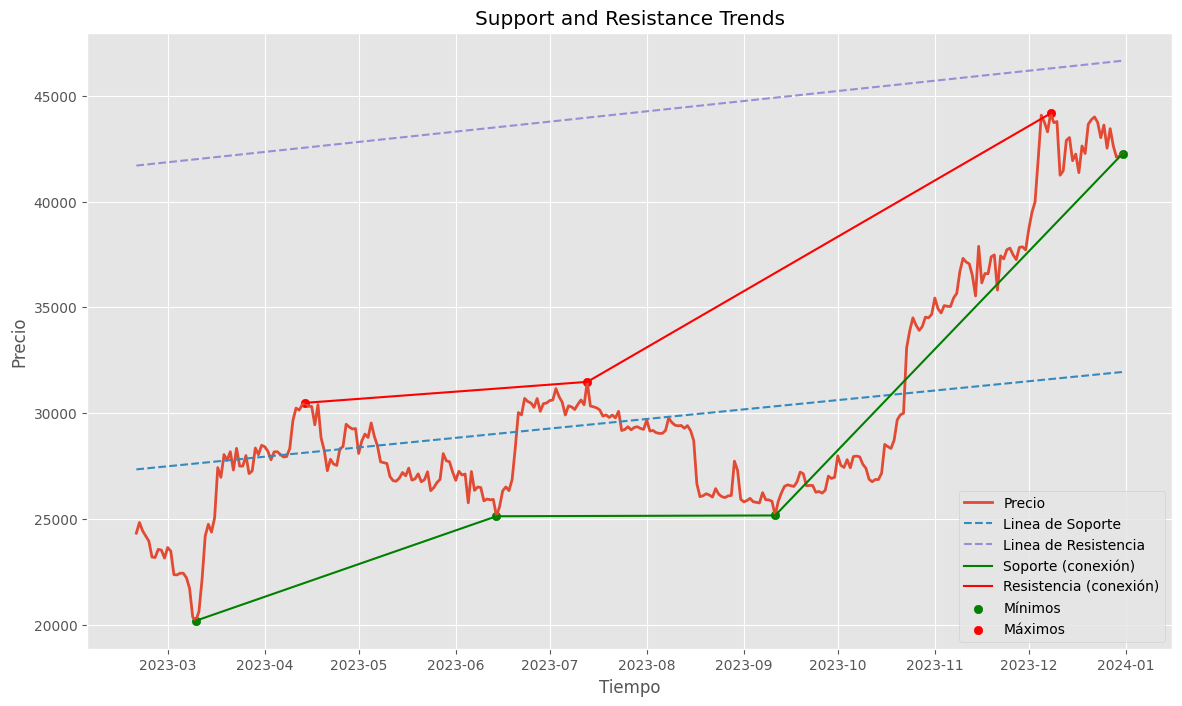

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


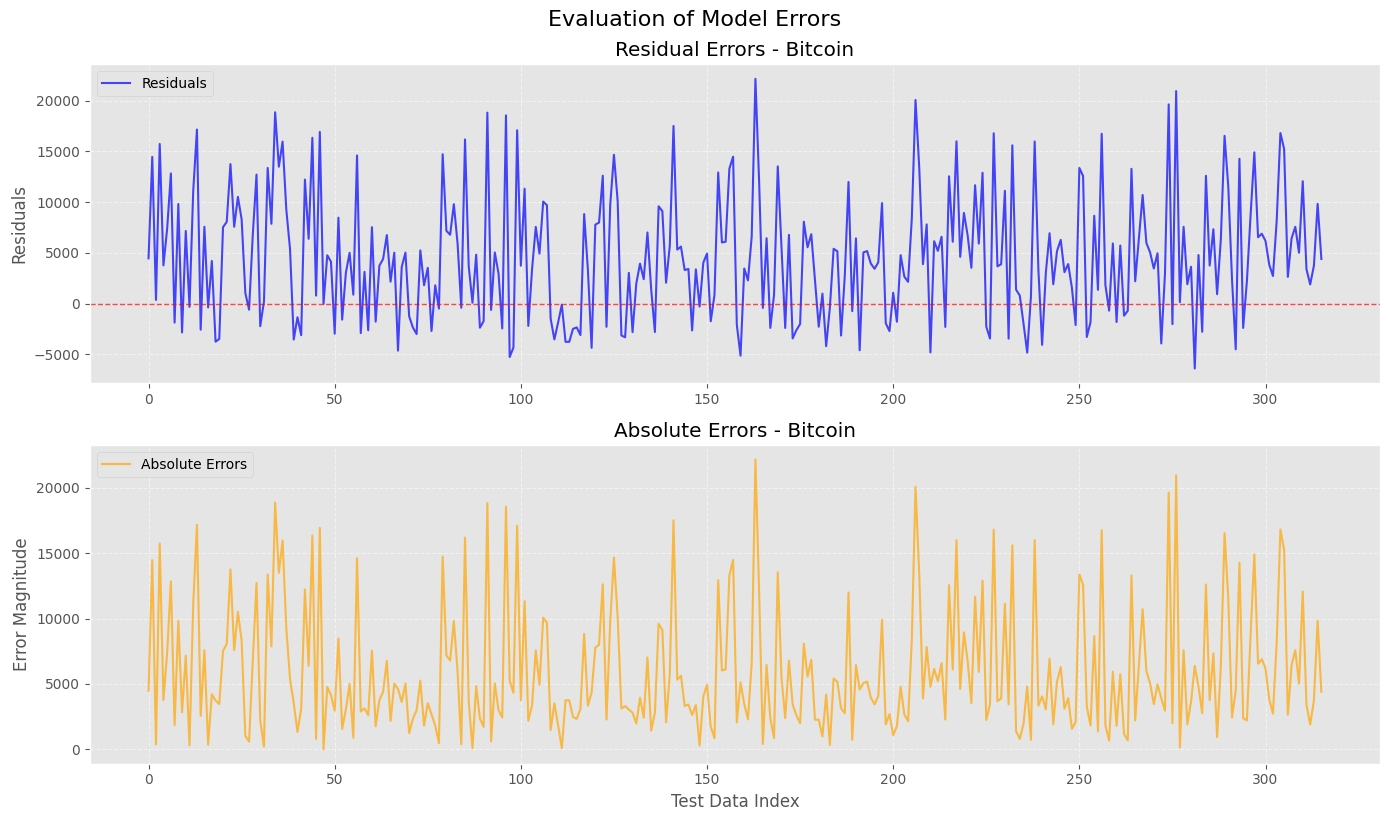


Error Analysis for Bitcoin:
  Mean Residual Error: 4615.4511
  Mean Absolute Error: 6004.7299
  Max Absolute Error: 22153.8635
  Min Absolute Error: 11.3570


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from scipy.signal import argrelextrema
from scipy.signal import find_peaks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, BatchNormalization, Conv1D, MaxPooling1D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
import yfinance as yf
import warnings

#configuracion inicial
warnings.filterwarnings("ignore")
plt.style.use('ggplot')
np.random.seed(42)

def fetch_yahoo_data(ticker, start_date, end_date):
    #obtiene datos historicos de Yahoo Finance
    print(f"Fetching data for {ticker}...")
    data = yf.download(ticker, start=start_date, end=end_date)
    if data.empty:
        raise ValueError(f"No data found for {ticker}.")
    data = data[['Close', 'Volume']]
    data.columns = ['price', 'volume']
    data.dropna(inplace=True)
    print(f"Data fetched: {data.shape[0]} rows.")
    return data

# caluculo de metodos de Trading

def calculate_rsi(data, period=14):
    #calcula el RSI 
    delta = data['price'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_macd(data, column='price', short_window=12, long_window=26, signal_window=9):
    #calcula el MACD y la señal del MACD
    short_ema = data[column].ewm(span=short_window, adjust=False).mean()
    long_ema = data[column].ewm(span=long_window, adjust=False).mean()
    macd = short_ema - long_ema
    signal = macd.ewm(span=signal_window, adjust=False).mean()
    return macd, signal

def analyze_trend(data):
    prices = np.array(data['price'].values, dtype=float)
    window = 30

    #identificacion de maximos y minimos locales usando argrelextrema
    min_indices = argrelextrema(prices, np.less, order=window)[0]
    max_indices = argrelextrema(prices, np.greater, order=window)[0]

    #captura de posibles extremos al final de la serie temporal
    if len(prices) - max_indices[-1] > window:
        max_indices = np.append(max_indices, len(prices) - 1)
    if len(prices) - min_indices[-1] > window:
        min_indices = np.append(min_indices, len(prices) - 1)

    #calculo de linea de tendencia usando regresion lineal
    def linear_regression_line(indices):
        indices = [i for i in indices if 0 <= i < len(prices)]
        if len(indices) < 2:
            return np.full(len(prices), np.nan)
        coef = np.polyfit(indices, prices[indices], 1)
        return coef[0] * np.arange(len(prices)) + coef[1]

    support_trend = linear_regression_line(min_indices)
    resistance_trend = linear_regression_line(max_indices)

    return {
        'support_trend': support_trend,
        'resistance_trend': resistance_trend,
        'min_indices': min_indices,
        'max_indices': max_indices
    }

def add_technical_indicators(data):
    #anadimos indicadores tecnicos al dataframe
    short_window = 20
    long_window = 50

    print("Adding technical indicators...")

    #calculo de RSI
    data['rsi'] = calculate_rsi(data)

    #calculo de MACD y señal
    data['macd'], data['macd_signal'] = calculate_macd(data)

    #calculo de SMA y EMA
    data['sma_50'] = data['price'].rolling(window=50).mean()
    data['sma_200'] = data['price'].rolling(window=200).mean()
    data['ema_20'] = data['price'].ewm(span=20, adjust=False).mean()

    #bandas de Bollinger
    data['bollinger_up'] = data['sma_50'] + (data['price'].rolling(window=50).std() * 2)
    data['bollinger_down'] = data['sma_50'] - (data['price'].rolling(window=50).std() * 2)

    #calculo de la volatilidad (desviacion ESTANDAR movil de 30 dias)
    data['volatility'] = data['price'].rolling(window=30).std()

    data.dropna(inplace=True)
    print(f"Technical indicators added: {data.shape[0]} rows remain.")

    return data

def preprocess_data(data):
    #preprocesamos los datos, escalándolos y creando secuencias
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)
    return scaled_data, scaler

def create_sequences(data, sequence_length):
    #creamos secuencias para entrenamiento LSTM
    sequences, labels = [], []
    for i in range(sequence_length, len(data)):
        sequences.append(data[i-sequence_length:i])
        labels.append(data[i, 0])  #precio como objetivo
    return np.array(sequences), np.array(labels)

def build_lstm_model(input_shape):
    #construimos un modelo LSTM avanzado con capas ocultas densas adicionales
    model = Sequential([
        #capa CNN para extraccipn de características locales
        Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=input_shape, padding='same'),
        MaxPooling1D(pool_size=2),
        BatchNormalization(),
        
        #capas lstm con mayor profundidad
        LSTM(256, return_sequences=True, kernel_regularizer=l2(0.01)),
        Dropout(0.3),
        BatchNormalization(),
        LSTM(128, return_sequences=True, kernel_regularizer=l2(0.01)),
        Dropout(0.3),
        BatchNormalization(),
        LSTM(64, return_sequences=False, kernel_regularizer=l2(0.01)),
        Dropout(0.3),
        BatchNormalization(),
        
        #capa oculta densa para mayor aprendizaje no lineal
        Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.3),
        
        #capa de salida
        Dense(1, activation='linear')
    ])
    
    #compilamos con Adam y un bajo learning_rate para realizar mas epocas y asi mayor convergencia
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae', 'mse'])

    return model

def simulate_trading(data, predictions, cooldown_period=20):
    """simulamos una estrategia de trading con un periodo de enfriamiento entre operaciones"""
    balance = 10000  # balance inicial en dolares
    initial_balance = balance
    position = 0  # posicion actual (cantidad de criptomonedas)
    trade_log = []  # lista para almacenar las operaciones
    cooldown = 0  # contador de enfriamiento

    base_stop_loss = 0.05
    base_take_profit = 0.05

    for i in range(1, len(predictions)):
        price = data['price'].iloc[i]
        prev_price = data['price'].iloc[i - 1]
        prediction = predictions[i]

        #decremento del cooldown
        if cooldown > 0:
            cooldown -= 1

        """
        #debugging: Check conditions
        rsi_condition = data['rsi'].iloc[i] < 30
        macd_condition = data['macd'].iloc[i] > data['macd_signal'].iloc[i] - 0.001
        prediction_condition = prediction > prev_price * 0.98
        print(f"Index: {data.index[i]}, RSI: {data['rsi'].iloc[i]:.2f}, MACD: {data['macd'].iloc[i]:.5f}, "
            f"Signal: {data['macd_signal'].iloc[i]:.5f}, Prediction: {prediction:.2f}, "
            f"RSI Condition: {rsi_condition}, MACD Condition: {macd_condition}, Prediction Condition: {prediction_condition}")
        """

        #ajuste dinamico de stop loss y take profit
        stop_loss = base_stop_loss
        take_profit = base_take_profit

        #aumentar o reducir segun la volatilidad
        if data['volatility'].iloc[i] > 0.03:
            stop_loss += 0.01  #mas volatilidad, stop loss mas amplio
            take_profit += 0.01
        elif data['volatility'].iloc[i] < 0.01:
            stop_loss -= 0.01  #menos volatilidad, stop loss mas ajustado
            take_profit -= 0.01

        #ajuste adicional basado en RSI
        if data['rsi'].iloc[i] < 30:
            take_profit += 0.01  #RSI bajo, mayor probabilidad de recuperación
        elif data['rsi'].iloc[i] > 70:
            stop_loss += 0.01  #RSI alto, mayor probabilidad de corrección

        if position == 0 and cooldown == 0:  #abrir posición solo si no hay cooldown
            #condiciones para comprar
            if prediction > prev_price and data['rsi'].iloc[i] < 40 and data['macd'].iloc[i] > data['macd_signal'].iloc[i]:
                position = balance / price
                balance = 0
                trade_log.append({
                    'Action': 'Buy',
                    'Price': price,
                    'Balance': balance,
                    'Position': position,
                    'Index': data.iloc[i].name,
                    'Reason': f"RSI: {data['rsi'].iloc[i]:.2f}, MACD: {data['macd'].iloc[i]:.2f}, Prediction: {prediction:.2f}"})
                cooldown = cooldown_period  # Reset del cooldown

        elif position > 0:  #cerrar posición si se alcanza TP o SL
            profit_loss = (price - prev_price) / prev_price
            if profit_loss >= take_profit or profit_loss <= -stop_loss:
                balance = position * price
                position = 0
                trade_log.append({
                    'Action': 'Sell',
                    'Price': price,
                    'Balance': balance,
                    'Position': position,
                    'Index': data.iloc[i].name,
                    'Reason': f"Profit/Loss Triggered: {profit_loss:.2f}"})
                cooldown = cooldown_period  #reset del cooldown

    #cerrar cualquier posición restante al final de la simulacion
    if position > 0:
        balance = position * data['price'].iloc[-1]
        trade_log.append({'Action': 'Sell', 'Price': data['price'].iloc[-1], 'Balance': balance, 'Position': 0, 'Index': data.index[-1]})

    #convertir trade_log en un dataframe
    trades = pd.DataFrame(trade_log)

    #debug:comprobar log de trades
    if trades.empty:
        print("WARNING: No trades were logged.")
    else:
        print("Trade log contents:")
        print(trades.head())

    #debug:verifica las columnas y el contenido de trades
    print("Trade log contents:")
    print(trades.head())

    #verificamos si la columna 'Index' está presente
    if 'Index' in trades.columns:
        trades.set_index('Index', inplace=True)
    else:
        print("ERROR: 'Index' column is missing in trade_log")

    # Cálculo del margen de beneficio
    profit_margin = balance - initial_balance
    print(f"\n\nINITIAL BALANCE: ${initial_balance:.2f}")
    print(f"FINAL BALANCE: ${balance:.2f}")
    print(f"PROFIT MARGIN: ${profit_margin:.2f}", "\n\n")

    return balance, trades

def evaluate_strategy(trades):
    """evalua la estrategia de trading y muestra metricas clave"""
    if trades.empty:
        print("No trades to evaluate.")
        return

    #calcula el drawdown maximo
    balance_over_time = trades['Balance'].values
    max_drawdown = np.max(np.maximum.accumulate(balance_over_time) - balance_over_time)
    max_drawdown_percentage = max_drawdown / np.maximum.accumulate(balance_over_time).max() * 100

    #calcula la tasa de exito
    trade_results = trades[trades['Action'] == 'Sell']['Balance'].diff().dropna()
    wins = trade_results[trade_results > 0].count()
    losses = trade_results[trade_results <= 0].count()
    win_rate = wins / (wins + losses) * 100 if (wins + losses) > 0 else 0

    #calcula la relación riesgo-recompensa
    average_win = trade_results[trade_results > 0].mean() if wins > 0 else 0
    average_loss = -trade_results[trade_results <= 0].mean() if losses > 0 else 0
    risk_reward_ratio = average_win / average_loss if average_loss > 0 else float('inf')

    print("Strategy Evaluation:")
    print(f"  Max Drawdown: ${max_drawdown:.2f} ({max_drawdown_percentage:.2f}%)")
    print(f"  Win Rate: {win_rate:.2f}%")
    print(f"  Risk-Reward Ratio: {risk_reward_ratio:.2f}")
    print(f"  Total Trades: {len(trades)}")
    print(f"  Total Wins: {wins}, Total Losses: {losses}")

def visualize_price_and_trades(data, trades, title, crypto_name):
    """visualiza los resultados de la estrategia de trading"""
    plt.figure(figsize=(14, 8))

    #precio de la criptomoneda
    plt.plot(data.index, data['price'].values, label=f'{crypto_name} Price', color='blue', linewidth=2)

    #graficar las senales de buy y sell
    buy_signals = trades[trades['Action'] == 'Buy']
    sell_signals = trades[trades['Action'] == 'Sell']

    #si hay operaciones, graficar señales de buy y sell
    if not trades.empty:
        buy_signals = trades[trades['Action'] == 'Buy']
        sell_signals = trades[trades['Action'] == 'Sell']

        plt.scatter(buy_signals.index, buy_signals['Price'], color='green', label='Buy Signal', marker='^', alpha=1)
        plt.scatter(sell_signals.index, sell_signals['Price'], color='red', label='Sell Signal', marker='v', alpha=1)
    else:
        print("No trade signals to display.")

    #conectar compras y ventas con lineas
    for i in range(0, len(trades) - 1, 2):
        buy = trades.iloc[i]
        sell = trades.iloc[i + 1]
        plt.plot([buy.name, sell.name], [buy['Price'], sell['Price']], color='gray', linestyle='--', alpha=0.6)

    #anadir anotaciones para los puntos de compra y venta
    for idx, row in trades.iterrows():
        if row['Action'] == 'Buy':
            plt.annotate('Buy', (idx, row['Price']), textcoords="offset points", xytext=(-15, 10), ha='center', fontsize=9, color='green')
        elif row['Action'] == 'Sell':
            plt.annotate('Sell', (idx, row['Price']), textcoords="offset points", xytext=(-15, -15), ha='center', fontsize=9, color='red')

    plt.title(f"{title} for {crypto_name}")
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend(loc='upper left')
    plt.show()

def visualize_indicators(data):
    """visualiza indicadores técnicos (RSI y MACD)"""
    fig, axs = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

    #subgrafico 1: RSI
    axs[0].plot(data.index, data['rsi'], label='RSI', color='orange', linewidth=2)
    axs[0].axhline(30, color='red', linestyle='--', alpha=0.7, label='RSI 30')
    axs[0].axhline(70, color='green', linestyle='--', alpha=0.7, label='RSI 70')
    axs[0].set_title('Relative Strength Index (RSI)')
    axs[0].legend(loc='upper left')

    # Subgráfico 2: MACD
    axs[1].plot(data.index, data['macd'], label='MACD', color='purple', linewidth=2)
    axs[1].plot(data.index, data['macd_signal'], label='Signal Line', color='green', linestyle='--')
    axs[1].set_title('MACD and Signal Line')
    axs[1].legend(loc='upper left')

    plt.xlabel('Time')
    plt.tight_layout()
    plt.show()

def visualize_trend(data, trend_data, title="Support and Resistance Trends"):
    """Visualiza las lineas de soporte y resistencia en el marco temporal correcto"""

    #extraer precios y tiempo del subconjunto de datos
    prices = data['price'].values
    time = data.index

    #extraer tendencias completas
    full_support_trend = trend_data.get("support_trend", np.full(len(prices), np.nan))
    full_resistance_trend = trend_data.get("resistance_trend", np.full(len(prices), np.nan))

    #alinear las tendencias al rango de datos actual
    aligned_support_trend = full_support_trend[-len(prices):] if len(full_support_trend) > len(prices) else np.pad(
        full_support_trend, (len(prices) - len(full_support_trend), 0), constant_values=np.nan
    )
    aligned_resistance_trend = full_resistance_trend[-len(prices):] if len(full_resistance_trend) > len(prices) else np.pad(
        full_resistance_trend, (len(prices) - len(full_resistance_trend), 0), constant_values=np.nan
    )

    #filtrar índices validos para los minimos y maximos
    valid_min_indices = [idx for idx in trend_data['min_indices'] if idx >= (len(trend_data['support_trend']) - len(prices))]
    valid_max_indices = [idx for idx in trend_data['max_indices'] if idx >= (len(trend_data['resistance_trend']) - len(prices))]

    #ajustar los índices validos al rango actual
    adjusted_min_indices = [idx - (len(trend_data['support_trend']) - len(prices)) for idx in valid_min_indices]
    adjusted_max_indices = [idx - (len(trend_data['resistance_trend']) - len(prices)) for idx in valid_max_indices]

    #graficar las lineas de tendencia
    plt.figure(figsize=(14, 8))
    plt.plot(time, prices, label='Precio', linewidth=2)
    plt.plot(time, aligned_support_trend, label='Linea de Soporte', linestyle='--')
    plt.plot(time, aligned_resistance_trend, label='Linea de Resistencia', linestyle='--')

    #conectar los puntos minimos y maximos con líneas
    if adjusted_min_indices:
        plt.plot(time[adjusted_min_indices], prices[adjusted_min_indices], color='green', label='Soporte (conexión)', linestyle='-', linewidth=1.5)
    if adjusted_max_indices:
        plt.plot(time[adjusted_max_indices], prices[adjusted_max_indices], color='red', label='Resistencia (conexión)', linestyle='-', linewidth=1.5)

    #graficar puntos minimos y maximos
    if adjusted_min_indices:
        plt.scatter(time[adjusted_min_indices], prices[adjusted_min_indices], color='green', label='Mínimos')
    if adjusted_max_indices:
        plt.scatter(time[adjusted_max_indices], prices[adjusted_max_indices], color='red', label='Máximos')

    plt.title(title)
    plt.xlabel('Tiempo')
    plt.ylabel('Precio')
    plt.legend()
    plt.grid(True)
    plt.show()

def visualize_errors(model, X_test, y_test, scaler, title="Model Errors", asset_name="Asset"):
    #Visualizar errores residuales y absolutos entre predicciones y valores reales
    
    #predicciones
    predictions = model.predict(X_test)
    
    #ajustar las predicciones a las dimensiones del escalador
    predictions_padded = np.hstack([predictions, np.zeros((predictions.shape[0], scaler.min_.shape[0] - 1))])
    predictions_rescaled = scaler.inverse_transform(predictions_padded)[:, 0]  #solo la columna de precios
    
    #ajustar los valores reales y_test 
    y_test_padded = np.hstack([y_test.reshape(-1, 1), np.zeros((y_test.shape[0], scaler.min_.shape[0] - 1))])
    y_test_rescaled = scaler.inverse_transform(y_test_padded)[:, 0]  #solo la columna de precios

    #calcular errores
    residuals = y_test_rescaled - predictions_rescaled  #errores residuales
    absolute_errors = np.abs(residuals)  #errores absolutos

    plt.figure(figsize=(14, 8))

    #subgrafico 1: errores residuales
    plt.subplot(2, 1, 1)
    plt.plot(residuals, label="Residuals", color="blue", alpha=0.7)
    plt.axhline(0, color="red", linestyle="--", linewidth=1, alpha=0.7)
    plt.title(f"Residual Errors - {asset_name}")
    plt.ylabel("Residuals")
    plt.legend(loc="upper left")
    plt.grid(True, linestyle="--", alpha=0.5)

    #subgrafico 2: errores absolutos
    plt.subplot(2, 1, 2)
    plt.plot(absolute_errors, label="Absolute Errors", color="orange", alpha=0.7)
    plt.title(f"Absolute Errors - {asset_name}")
    plt.xlabel("Test Data Index")
    plt.ylabel("Error Magnitude")
    plt.legend(loc="upper left")
    plt.grid(True, linestyle="--", alpha=0.5)

    #ajustar diseño y mostrar
    plt.tight_layout()
    plt.suptitle(title, y=1.02, fontsize=16)
    plt.show()

    # Imprimir estadísticas de errores
    print(f"\nError Analysis for {asset_name}:")
    print(f"  Mean Residual Error: {np.mean(residuals):.4f}")
    print(f"  Mean Absolute Error: {np.mean(absolute_errors):.4f}")
    print(f"  Max Absolute Error: {np.max(absolute_errors):.4f}")
    print(f"  Min Absolute Error: {np.min(absolute_errors):.4f}")

#main Program
graph_title = "Crypto Trading Simulation"
crypto_name = "BTC-USD"

#TRAIN WITH X YEARS
crypto_data = fetch_yahoo_data(crypto_name, '2019-01-01', '2024-01-01')

# agregar indicadores al analisis
crypto_data = add_technical_indicators(crypto_data)

# analizar tendencia grafica
trend_data = analyze_trend(crypto_data)

sequence_length = 50

scaled_data, scaler = preprocess_data(crypto_data.values)
X, y = create_sequences(scaled_data, sequence_length)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = build_lstm_model((X_train.shape[1], X_train.shape[2]))

#batch overdimensioned due to big datasets
model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2) 

predictions = model.predict(X_test)
predictions_rescaled = scaler.inverse_transform(np.hstack((predictions, np.zeros((predictions.shape[0], scaled_data.shape[1] - 1)))))[:, 0]

final_balance, trades = simulate_trading(crypto_data.iloc[-len(predictions):], predictions_rescaled)
evaluate_strategy(trades)

#debugging: Check trades DataFrame
print("Trades DataFrame:")
print(trades)

#verify model Predictions
print("Predictions vs Actual Prices:")
print(pd.DataFrame({'Prediction': predictions_rescaled[:5], 'Actual': crypto_data['price'].iloc[-len(predictions):].head().values}))

#visualize trading results (ONLY FOR 1 YEAR TRADE GRAPHIC)
visualize_price_and_trades(data=crypto_data.iloc[-len(predictions):], trades=trades, title="Buy and Sell Trade", crypto_name='Bitcoin')
visualize_indicators(data=crypto_data.iloc[-len(predictions):])
visualize_trend(data=crypto_data.iloc[-len(predictions):], trend_data=trend_data, title="Support and Resistance Trends")
visualize_errors(model=model, X_test=X_test, y_test=y_test, scaler=scaler, title="Evaluation of Model Errors", asset_name="Bitcoin")